In [1]:
import numpy as np
from enum import Enum
from scipy.optimize import minimize_scalar
from scipy.stats import norm
class CopulaTypes(Enum):
    """ Available copula families. """

    GUMBEL = 2
    INDEPENDENCE = 3

class Bivariate(object):
    """
        Base class for bivariate copulas.

        This class allows to instantiate all is subclasses and serves
        as a unique entry point for the bivariate copulas classes.

        Inputs
        ------
            copula_type : subtype of the copula
            random_seed : Seed for the random generator

        Attributes
        ----------
            copula_type(CopulaTypes) : Family of the copula a subclass belongs to
            theta_interval(list[float]) : Interval of vlid thetas for the given copula family
            invalid_thetas(list[float]) : Values that, even though they belong to
                :attr:`theta_interval`, shouldn't be considered valid.
            theta(float) : Parameter for the copula
    """
    copula_type = None
    _subclasses = []
    theta_interval = []
    invalid_thetas = []
    theta = []
    n_sample = []

    def __init__(self, copula_type = None, random_seed = None, theta = None, n_sample = None):
        """
            Initialize Bivariate object.

            Args:
            -----
                Copula_type (CopulaType or str) : subtype of the copula.
                random_seed (int or None) : Seed for the random generator
                theta (float or None) : Parameter for the copula.
        """
        self.random_seed = random_seed
        self.theta = theta
        self.n_sample = n_sample


class Gumbel(Bivariate):

    copula_type = CopulaTypes.GUMBEL
    theta_interval = [1,float('inf')]
    invalid_thetas = []

    def A(self, t):
        value_ = np.power(np.power(t, self.theta) + np.power(1-t, self.theta), 1/self.theta)
        return(value_)

    def Aprime(self, t):
        value_1 = np.power(t, self.theta -1) - np.power(1-t, self.theta-1)
        value_2 = np.power(t, self.theta) + np.power(1-t, self.theta)
        value_ = value_1*np.power(value_2, (1/self.theta)-1)
        return value_

    def kappa(self, lmbd):
        value_ = self.A(lmbd) - lmbd*self.Aprime(lmbd)
        return(value_)

    def zeta(self, lmbd):
        value_ = self.A(lmbd) + (1-lmbd)*self.Aprime(lmbd)
        return(value_)

    def f(self, lmbd):
        value_ = np.power(lmbd*(1-lmbd)/(self.A(lmbd) + lmbd*(1-lmbd)),2)
        return(value_)

    def f1(self, lmbd, h, x):
        value_1 = x * np.power(1-x,3) * h(lmbd)
        value_2 = (self.A(lmbd) + lmbd*(1-lmbd))*(self.A(lmbd) + (1-x))
        value_ = value_1 / value_2
        return(value_)

    def f2(self, lmbd, h, x):
        value_1 = x*(1-x)*h(lmbd)
        value_2 = self.A(lmbd) - (1-x) + lmbd*(1-lmbd)
        value_3 = x*(1-x) / (self.A(lmbd) + x - (1-x) + 2*lmbd*(1-lmbd))
        value_4 = np.power(1-x,2) / (self.A(lmbd) + (1-x))
        value_  = (value_1 / value_2) * (value_3 - value_4)
        return(value_)

    def f_kappa(self,lmbd):
        if lmbd > 0.5 :
            value_ = self.f1(lmbd, self.kappa, lmbd) + self.f2(lmbd, self.kappa, lmbd)
            return(value_)
        else:
            value_1 = self.kappa(lmbd) * np.power(lmbd*(1-lmbd), 2)
            value_2 = (self.A(lmbd) + lmbd*(1-lmbd))*(self.A(lmbd) + 2*lmbd*(1-lmbd))
            value_ = value_1 / value_2
            return(value_)

    def f_zeta(self, lmbd):
        if lmbd > 0.5 :
            value_1 = self.zeta(lmbd) * np.power(lmbd*(1-lmbd),2)
            value_2 = (self.A(lmbd) + lmbd*(1-lmbd))*(self.A(lmbd) + 2*lmbd*(1-lmbd))
            value_ = value_1 / value_2
            return(value_)
        else :
            value_ = self.f1(lmbd, self.zeta, 1-lmbd) + self.f2(lmbd, self.zeta, 1-lmbd)
            return(value_)

    def common(self, lmbd):
        value_1 = 1 / (self.A(lmbd) + 2*lmbd*(1-lmbd))
        value_2 = np.power(self.kappa(lmbd),2) * (1-lmbd) / (2*self.A(lmbd) - (1-lmbd) + 2*lmbd*(1-lmbd))
        value_3 = np.power(self.zeta(lmbd),2) * lmbd / (2*self.A(lmbd) - lmbd + 2*lmbd*(1-lmbd))
        return self.f(lmbd)* (value_1 + value_2 + value_3)

    def lower(self, lmbd):
        ### second term
        value_1 = (np.power(1-lmbd,2) - self.A(lmbd)) / (2*self.A(lmbd) - (1-lmbd) + 2*lmbd*(1-lmbd))
        value_1 = 2*self.kappa(lmbd) * self.f(lmbd) * (value_1) + 2*self.f_kappa(lmbd)
        ### third term
        value_2 = (np.power(lmbd,2) - self.A(lmbd)) / (2*self.A(lmbd) - lmbd + 2*lmbd*(1-lmbd))
        value_2 = 2*self.zeta(lmbd) * self.f(lmbd) * value_2 + 2 *self.f_zeta(lmbd)
        ### result
        value_ = self.common(lmbd) - value_1 - value_2
        return(value_)

    def upper(self, lmbd):
        ### second term
        value_1 = (1-lmbd) / (2*self.A(lmbd) - (1-lmbd) + 2 * lmbd*(1-lmbd)) + (self.A(lmbd) - lmbd) / (self.A(lmbd) + lmbd + 2*lmbd*(1-lmbd))
        value_1 = self.kappa(lmbd) * self.f(lmbd) * value_1
        ### third term
        value_2 = lmbd / (2*self.A(lmbd) - lmbd + 2*lmbd*(1-lmbd)) + (self.A(lmbd) - (1-lmbd)) / (self.A(lmbd) + 1 - lmbd + 2*lmbd*(1-lmbd))
        value_2 = self.zeta(lmbd) * self.f(lmbd) * value_2
        ### fourth term
        value_3 = (self.zeta(lmbd) * self.kappa(lmbd) * lmbd*(1-lmbd)) / self.A(lmbd)
        value_3 = 2 * self.f(lmbd) * value_3
        ### result
        value_ = self.common(lmbd) - value_1 - value_2  + value_3
        return(value_)
        

    def generate_randomness(self):
        """
            Generate a bivariate sample draw identically and
            independently from a uniform over the segment [0,1]

            Inputs
            ------
            self.n_sample : length of the bivariate sample

            Outputs
            -------
            n_sample x 2 np.array
        """

        v_1 = np.random.uniform(low = 0.0, high = 1.0, size = self.n_sample) # first sample
        v_2 = np.random.uniform(low = 0.0, high = 1.0, size = self.n_sample) # second sample
        output_ = np.vstack([v_1, v_2]).T
        return output_

    def generator(self, t):
        """
            Return the generator function

            Inputs
            ------
            t : value of the generator
            self.theta : parameter of the copula fonction

            Outputs
            -------
            real number
        """
        value_ = np.power((-np.log(t)),self.theta)
        return(value_)
    
    def K_c(self, t):
        """
            Return the derivative of the generator function
        """
        value_ = t*(1-(np.log(t)/self.theta))
        return value_

    def sample_unimargin(self):
        output = np.zeros((self.n_sample,2))
        X = self.generate_randomness()
        for i in range(0,self.n_sample):
            v = X[i]
            def func(x):
                value_ = np.abs(self.K_c(x) - v[1])
                return(value_)
            sol = minimize_scalar(func, bounds = (0,1), method = "bounded")
            sol = float(sol.x)
            u = [np.exp(np.power(v[0],1/self.theta)*np.log(sol)) , np.exp(np.power(1-v[0],1/self.theta)*np.log(sol))]
            output[i,:] = u
        return output

    def sample(self):
        intput = self.sample_unimargin()
        output = np.zeros((self.n_sample,2))
        ncol = intput.shape[1]
        for i in range(0, ncol):
            output[:,i] = norm.ppf(intput[:,i])

        return (output)

        


#copula = Gumbel(copula_type= "GUMBEL", random_seed= 42, theta=2, n_sample = 1)
#x = np.linspace(0,1.0,5)
#print(x)
#values = [copula.f2(lmb, copula.zeta, 1-lmb) for lmb in x]
#print(values)

Text(0.5, 1.0, 'Observed data')

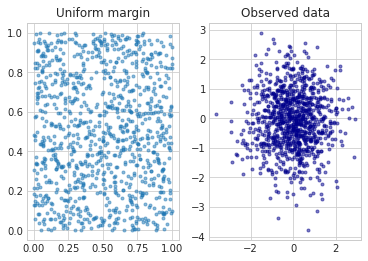

In [2]:
copula = Gumbel(copula_type = "GUMBEL", random_seed = 42, theta = 1, n_sample = 1000)
unif = copula.sample_unimargin()
data = copula.sample()
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
figure, axis = plt.subplots(1, 2)

axis[0].plot(unif[:,0],unif[:,1], '.', alpha = 0.5)
axis[0].set_title("Uniform margin")
axis[1].plot(data[:,0],data[:,1], '.', alpha = 0.5, c = 'darkblue')
axis[1].set_title("Observed data")

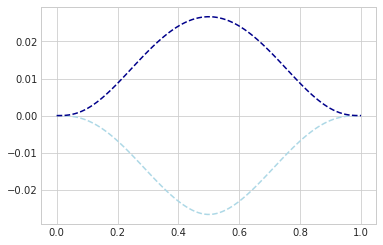

In [3]:
x = np.linspace(0,1,100)
values_upper = [copula.upper(lmbd) for lmbd in x]
values_lower = [copula.lower(lmbd) for lmbd in x]

fig, ax = plt.subplots()

plt.plot(x, values_lower, "lightblue", linestyle = '--')
plt.plot(x, values_upper, "darkblue", linestyle='--')

Text(0.5, 1.0, 'Observed data')

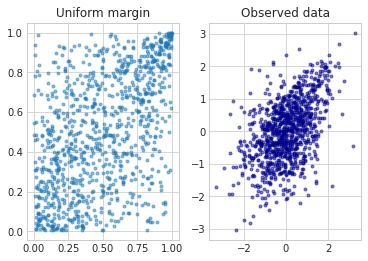

In [4]:
copula = Gumbel(copula_type = "GUMBEL", random_seed = 42, theta = 1.5, n_sample = 1000)
unif = copula.sample_unimargin()
data = copula.sample()
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
figure, axis = plt.subplots(1, 2)

axis[0].plot(unif[:,0],unif[:,1], '.', alpha = 0.5)
axis[0].set_title("Uniform margin")
axis[1].plot(data[:,0],data[:,1], '.', alpha = 0.5, c = 'darkblue')
axis[1].set_title("Observed data")

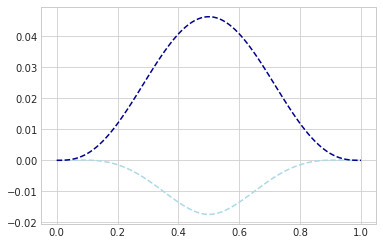

In [5]:
x = np.linspace(0,1,100)
values_upper = [copula.upper(lmbd) for lmbd in x]
values_lower = [copula.lower(lmbd) for lmbd in x]

fig, ax = plt.subplots()

plt.plot(x, values_lower, "lightblue", linestyle = '--')
plt.plot(x, values_upper, "darkblue", linestyle='--')

Text(0.5, 1.0, 'Observed data')

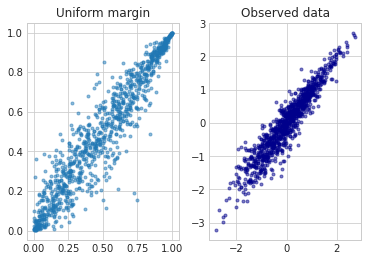

In [6]:
copula = Gumbel(copula_type = "GUMBEL", random_seed = 42, theta = 5, n_sample = 1000)
unif = copula.sample_unimargin()
data = copula.sample()
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
figure, axis = plt.subplots(1, 2)

axis[0].plot(unif[:,0],unif[:,1], '.', alpha = 0.5)
axis[0].set_title("Uniform margin")
axis[1].plot(data[:,0],data[:,1], '.', alpha = 0.5, c = 'darkblue')
axis[1].set_title("Observed data")

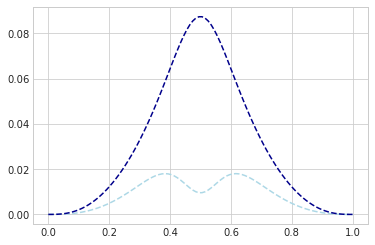

In [7]:
x = np.linspace(0,1,100)
values_upper = [copula.upper(lmbd) for lmbd in x]
values_lower = [copula.lower(lmbd) for lmbd in x]

fig, ax = plt.subplots()

plt.plot(x, values_lower, "lightblue", linestyle = '--')
plt.plot(x, values_upper, "darkblue", linestyle='--')

Text(0.5, 1.0, 'Observed data')

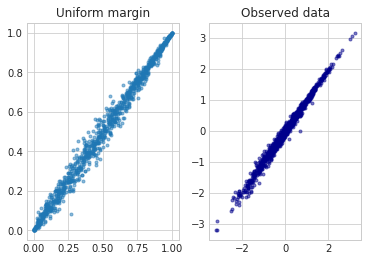

In [8]:
copula = Gumbel(copula_type = "GUMBEL", random_seed = 42, theta = 15, n_sample = 1000)
unif = copula.sample_unimargin()
data = copula.sample()
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
figure, axis = plt.subplots(1, 2)

axis[0].plot(unif[:,0],unif[:,1], '.', alpha = 0.5)
axis[0].set_title("Uniform margin")
axis[1].plot(data[:,0],data[:,1], '.', alpha = 0.5, c = 'darkblue')
axis[1].set_title("Observed data")

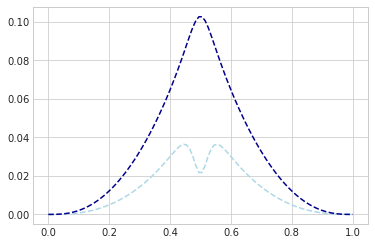

In [9]:
x = np.linspace(0,1,100)
values_upper = [copula.upper(lmbd) for lmbd in x]
values_lower = [copula.lower(lmbd) for lmbd in x]

fig, ax = plt.subplots()

plt.plot(x, values_lower, "lightblue", linestyle = '--')
plt.plot(x, values_upper, "darkblue", linestyle='--')